# Practice on Monte Carlo Tree Search (MCTS)

Steps:
1. function <uct_policy>
2. function <expand>
After step 1 and 2, you can run <test_select_expand> section to assess your code. It should output the correct tree stucture.
1. function <rollout>


In [1]:
import numpy as np 
from scipy.special import softmax 
import time 


from IPython.display import clear_output
%matplotlib inline
%config InlineBackend.figure_format='retina'

import matplotlib.pyplot as plt 
import seaborn as sns 
import networkx as nx 

import sys 
sys.path.append("..") 
from utils.env import frozen_lake
from utils.viz import viz 
viz.get_style()

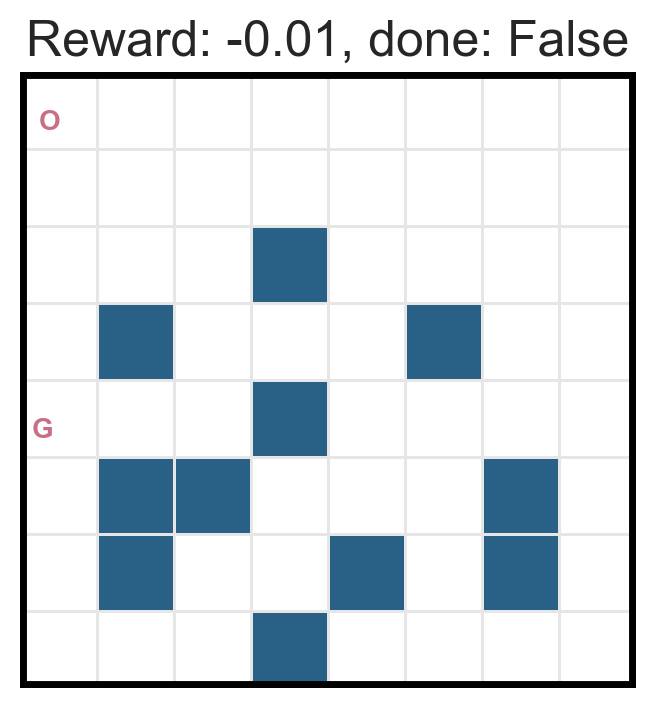

In [2]:
# The frozen lake 
layout = [
    "S.......",
    "........",
    "...H....",
    ".H...H..",
    "G..H....",
    ".HH...H.",
    ".H..H.H.",
    "...H...."
]
env = frozen_lake(layout=layout, Rscale=10)
env.reset()
fig, ax = plt.subplots(1, 1, figsize=(4, 4))
env.render(ax)

# 1. MCTS implementation

## MCTS: basic 

In [3]:
# two types of nodes
class Node_s:
    type = 'state' # state nodes

    def __init__(self, s, parent=None):
        self.s = s
        self.n = 1 
        self.v = 0
        self.name = f's={s}'
        self.parent = parent
        if self.parent is not None:
            self.parent.children.append(self)
        self.children = []

class Node_a:
    type = 'action'

    def __init__(self, a, parent=None):
        self.a = a
        self.n = 1
        self.v = 0
        self.name = f'a={a}'
        self.parent = parent 
        if self.parent is not None:
            self.parent.children.append(self)
        self.children = []

## MCTS: select and expand

In [4]:
class MTCS:
    def __init__(self, model, c=.1, max_iter=100, seed=227):
        '''
        <model>: the environment object, e.g., env
        <c>: parameter to balance exploit and exploration. large c = largen tendency for exploration
        <rng>: the object to generate random samples and choices, set by e.g. rng = np.random.RandomState  (0)
        '''
        self.model = model 
        self.c     = c
        self.rng   = np.random.RandomState(seed)
        self.max_iter = max_iter

    def plan(self, s):
        '''Plan with MCTS
        <s>: int, the current state index,
        <max_iter>: int, the number of tree search
        '''
        root = Node_s(s)
        for _ in range(self.max_iter):
            node, r_search = self.select_expand(root)
            r_rollout  = self.rollout(node)
            self.backprop(node, r_search+r_rollout)
        a = self.uct_policy(root, c=0)
        del root
        return a
    
    def policy(self, s):
        return np.eye(self.model.nA)[self.plan(s)] 
    
    def learn(self, **kwargs):
        pass


In [5]:
def select_expand(self, s_node):
    '''Select & expand 
    Input
    <s_node>: starting state node object

    Output
    We return the next state node object and accumulated reward

    Find an s_node that is not fully expanded, expand
    it before moving to the rollout stage. 
    
    if s_node is not the termination node (usually not)
    we do:
        1. check if the current node is fully expanded
        2. if fully expanded, do select
        3. if not fully expnaded, do expand 
        4. use your mental model (self.model) to
            sample the next state (s_next), and
            the foresee the reward
        5. loop until we expand a s_node 

    hints:
        transition_fn: self.model.p_s_next(s,a)
        index a list: idx = list.index(element)
        use the random generator to do sampling: 
            self.rng.choice([], p=p)
            e.g. self.rng.choice(
                list(range(self.model.nS))), p=p) 
        construct a node: 
            s_next_node = Node_s(s=s, parent=a_node)
            a_node = Node_a(a=a. parent=s_node)
    '''
    # flag to track if we just expanded a new action node
    done = False
    # track accumulated reward along trajectory
    r_sum = 0
    
    # continue until we reach a terminal state
    while s_node.s not in self.model.s_termination:
        # if all actions have been tried from this state
        if self.fully_expanded(s_node):
            # select action using uct policy
            a = self.uct_policy(s_node, self.c)
            # find the corresponding action node
            a_lst = [child.a for child in s_node.children]
            a_node = s_node.children[a_lst.index(a)]
        else:
            # try a new unexplored action
            a = self.expand(s_node)
            # create new action node
            a_node = Node_a(a, parent=s_node)
            done = True 
            
        # sample the next state according to transition probabilities
        p_next = self.model.p_s_next(s_node.s, a)
        s_next = self.rng.choice(self.model.nS, p=p_next)
        # get reward for landing in this state
        r, _ = self.model.r(s_next)
        r_sum += r

        # check if this next state has been expanded before
        s_next_lst = [child.s for child in a_node.children]
        if s_next in s_next_lst:
            # reuse existing state node
            s_next_node = a_node.children[s_next_lst.index(s_next)]
        else:
            # create new state node
            s_next_node = Node_s(s_next, parent=a_node) 
        
        # move to next state
        s_node = s_next_node
        # stop if we just expanded a new action
        if done: break 

    return s_node, r_sum

def uct_policy(self, s_node, c=.1):
    '''Select a node from a fully expanded node
    using the UCT policy

    The ucb score for each node a is:
    score_a = V(a)/N(a) + c*sqrt{2*ln N(s)/N(a)}
    where c is the tradeoff parameter between
    exploitation (1st term) and explore (2nd term)

    Return: a: an action (0-4)  

    hints:
        N(s) = s_node.n
        N(a) = child.n
        V(a) - child.v
    '''
    # initialize empty lists for scores and actions
    score = [] 
    a_lst = []
    for child in s_node.children: # loop through all child nodes
        a_lst.append(child.a)
        # exploitation term is average value
        exploit = (child.v / child.n) 
        # exploration term uses ucb formula
        explore = np.sqrt(2*np.log(s_node.n) / child.n)
        # combine exploitation and exploration terms
        score.append(exploit + c*explore)
    # randomly choose among actions with maximum score
    idx = self.rng.choice(np.where(score==np.max(score))[0].tolist())  
    return a_lst[idx] 

def expand(self, s_node):
    ''''expand a child from the current state node
    three steps:
        1. get the selected action
        2. get the unselected action
        3. randomly (uniformly) choose an unselected
            action

    hints:
        s_node.children is a list of Node_a object
            get the action of Node_a: a = child.a 
        all_actioins = list(range(self.model.nA))
        set(c) = set(a) - set(b) 
    '''
    # get list of actions already selected from child nodes
    a_selected = [child.a for child in s_node.children]
    # find unselected actions by taking difference between all actions and selected ones
    a_unslected = set(list(range(self.model.nA))) - set(a_selected)
    # convert back to list
    a_unslected = list(a_unslected)
    # randomly choose an unselected action
    a = self.rng.choice(a_unslected)
    return a 

def fully_expanded(self, s_node):
    return len(s_node.children) == self.model.nA

MTCS.select_expand = select_expand
MTCS.uct_policy = uct_policy
MTCS.expand = expand
MTCS.fully_expanded = fully_expanded

In [6]:
# check your answer in uct_policy and expand. 
def viz_tree(node, deep=0):
    '''
    Visualize a tree structure
    '''
    key = node.name
    print('    |'*deep+'--'+key)
    for child in node.children:
        viz_tree(child, deep+1)
def test_backprop(node):
    while node is not None:
        node.n += 1
        node = node.parent
def test_select_expand(self, s=0, max_iter=20):
    root = Node_s(s)
    for _ in range(max_iter):
        node, _ = self.select_expand(root)
        test_backprop(node)
    viz_tree(root)

MTCS.test_select_expand = test_select_expand
MTCS(env, seed=227).test_select_expand(max_iter=12)

--s=0
    |--a=0
    |    |--s=0
    |    |    |--a=0
    |    |    |    |--s=1
    |    |    |--a=1
    |    |    |    |--s=1
    |--a=3
    |    |--s=1
    |    |    |--a=3
    |    |    |    |--s=9
    |    |    |--a=0
    |    |    |    |--s=9
    |--a=1
    |    |--s=8
    |    |    |--a=3
    |    |    |    |--s=9
    |    |    |--a=2
    |    |    |    |--s=8
    |--a=2
    |    |--s=0
    |    |    |--a=1
    |    |    |    |--s=8
    |    |    |--a=3
    |    |    |    |--s=1


In [7]:
def rollout(self, s_node):
    '''
    Given state node object <s_node>. We stats from s_node and run a simulation until reaching to an end
    '''
    # get initial state from node
    s = s_node.s 
    # initialize cumulative reward and done flag
    r_sum = 0 
    done = False
    depth = 0
    #max_depth = 1000
    while True:
        # randomly select an action
        a = self.rng.choice(self.model.nA)
        # get transition probabilities for next state
        p_next = self.model.p_s_next(s, a)
        # sample next state based on probabilities
        s_next = self.rng.choice(self.model.nS, p=p_next)
        # get reward and done flag for next state
        r, done = self.model.r(s_next)
        # accumulate reward
        r_sum += r
        # exit if done
        if done: break
        # update current state
        s = s_next 
    return r_sum
MTCS.rollout = rollout

In [8]:
def backprop(self, node, r_sum):
    '''
    Given the final state node object in a rollout, we compute the accumulated reward and number of arrival
    '''
    while node is not None:
        node.n += 1
        node.v += r_sum
        node = node.parent
MTCS.backprop = backprop

In [9]:
def plan(env, agent, max_epi=1):
  
    for epi in range(max_epi):
        s, r, done = env.reset()
        t = 0 #
        G = 0 # what is G
        while True:
            # sample At, observe Rt, St+1
            a = agent.plan(s)
            s_next, r, done = env.step(a)
     
            t += 1
            G += r
            s = s_next

            fig, ax = plt.subplots(1, 1, figsize=(4, 4))
            clear_output(True)
            env.render(ax)
            time.sleep(.1)
            plt.show()
            
            if done:
                break 

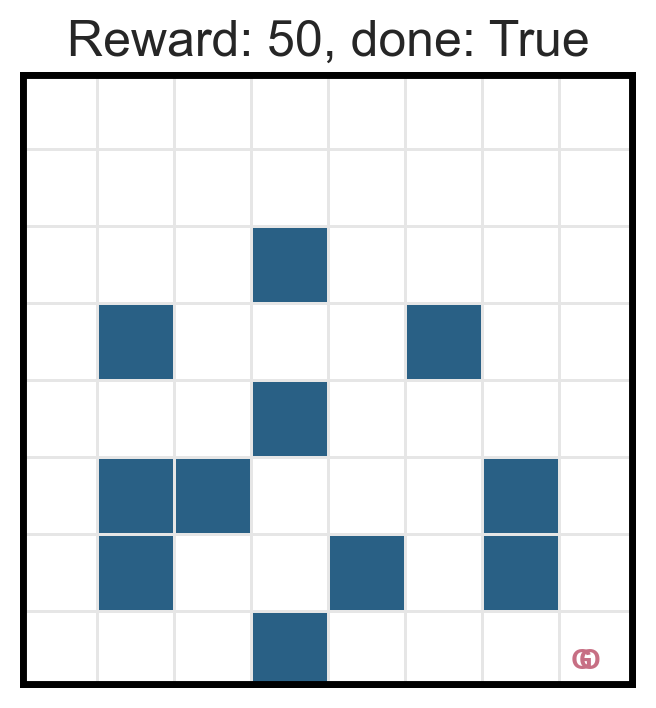

In [11]:
env = frozen_lake(Rscale=50, eps=.1, seed=2025)
agent = MTCS(
    model=env, 
    c=2, 
    max_iter=500, 
    seed=2024)
plan(env, agent)

# 2. Changing environment

In [49]:
def train(env, agent, seed=1234, verbose=False,
            show_intval=100, show_trajectory=False, 
            max_epi=10, max_steps=200):
    
    # initialization 
    rng = np.random.RandomState(seed)

    # init a list to record the model performance per step unit
    model_performance = []

    # loop over episodes 
    for epi in range(max_epi):

        agent.epi = epi
        s, _, _ = env.reset()
        step, r_cum = 0, 0
        while True:
            # agent the agent policy
            pi = agent.policy(s)
            # interact with the env
            a = rng.choice(env.A, p=pi)
            s_next, r, done = env.step(a)
            # agent the agent policy
            agent.learn(s=s, a=a, r=r, s_next=s_next, done=done)
            # update the state
            s = s_next
            # for evaluation
            step += 1
            r_cum += r
            
            # visualize the trajectory
            if show_trajectory and (epi%show_intval==0):
                fig, ax = plt.subplots(1, 1, figsize=(4.2, 4))
                clear_output(True)
                env.render(ax)
                time.sleep(.1)
                plt.show()

            # the end of the episode
            if done or (step>max_steps): 
                if verbose: print(f'episode: {epi}, step: {step}, r: {r_cum}')
                model_performance.append(r_cum)
                break

    return model_performance, agent

In [50]:
env = frozen_lake(Rscale=50, eps=.1, seed=2025)
agent = MTCS(model=env, c=2, max_iter=1000, seed=2024)
mp_mcts1, agent = train(env, agent, max_epi=10, verbose=True)
layout = [
    "S.......",
    "........",
    "...H....",
    ".H...H..",
    "G..H....",
    ".HH...H.",
    ".H..H.H.",
    "...H...."
]
env = frozen_lake(layout=layout, Rscale=50, eps=.1, seed=2025)
agent.model = env
mp_mcts2, agent = train(env, agent, max_epi=10, verbose=True)

episode: 0, step: 26, r: 49.75
episode: 1, step: 34, r: 49.67
episode: 2, step: 51, r: 49.5
episode: 3, step: 39, r: -1.3800000000000001
episode: 4, step: 38, r: 49.63
episode: 5, step: 36, r: 49.65
episode: 6, step: 39, r: 49.62
episode: 7, step: 51, r: 49.5
episode: 8, step: 44, r: 49.57
episode: 9, step: 53, r: 49.48
episode: 0, step: 5, r: 49.96
episode: 1, step: 15, r: 49.86
episode: 2, step: 8, r: 49.93
episode: 3, step: 7, r: -1.06
episode: 4, step: 29, r: -1.28
episode: 5, step: 5, r: 49.96
episode: 6, step: 15, r: 49.86
episode: 7, step: 29, r: 49.72
episode: 8, step: 14, r: 49.87
episode: 9, step: 21, r: 49.8


In [51]:
class Qlearn:
    def __init__(self, nS, nA, alpha=.1, eps=.1, gamma=.99): 
        self.alpha = alpha
        self.eps = eps
        self.gamma = gamma
        self.nS = nS
        self.nA = nA
        self.Q = np.zeros((nS, nA))

    def policy(self, s):
        # random policy
        pi_rand = np.ones(self.nA) / self.nA
        # greedy policy 
        q = self.Q[s]
        qmax = q==np.max(q)
        pi_greedy = qmax / qmax.sum()
        return self.eps*pi_rand + (1-self.eps)*pi_greedy
    
    def learn(self, **kwargs):
        s, a, r = kwargs['s'], kwargs['a'], kwargs['r']
        s_next, done = kwargs['s_next'], kwargs['done']
        # update Q value
        q_next = (1-done) * self.gamma * np.max(self.Q[s_next])
        self.Q[s, a] += self.alpha * (r + q_next - self.Q[s, a])


In [52]:
env = frozen_lake(Rscale=50, eps=.1, seed=2025)
agent = Qlearn(nS=env.nS, nA=env.nA, alpha=.1, eps=.1, gamma=.99)
mp_q1, agent = train(env, agent, max_epi=1000)
layout = [
    "S.......",
    "........",
    "...H....",
    ".H...H..",
    "G..H....",
    ".HH...H.",
    ".H..H.H.",
    "...H...."
]
env = frozen_lake(layout=layout, Rscale=50, eps=.1, seed=2025)
mp_q2, agent = train(env, agent, max_epi=1000)

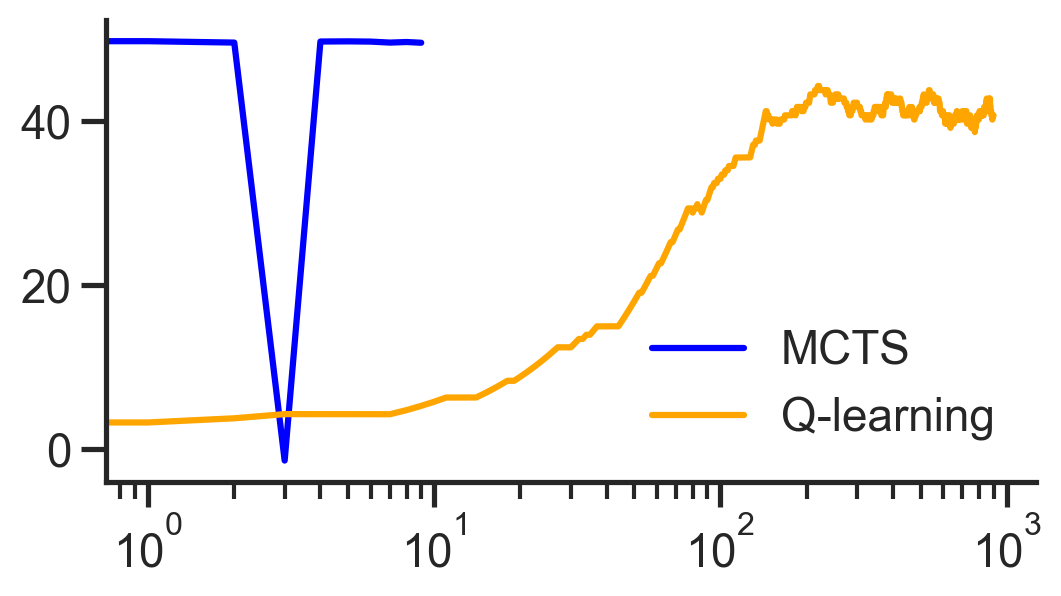

In [55]:
fig, ax = plt.subplots(1, 1, figsize=(6, 3))
smoothed_mp = np.convolve(mp_q1, np.ones(100)/100, mode='valid')
plt.plot(range(len(mp_mcts1)), mp_mcts1, label='MCTS', color='blue')
plt.plot(range(len(smoothed_mp)), smoothed_mp, label='Q-learning', color='orange')
plt.legend()
plt.xscale('log')

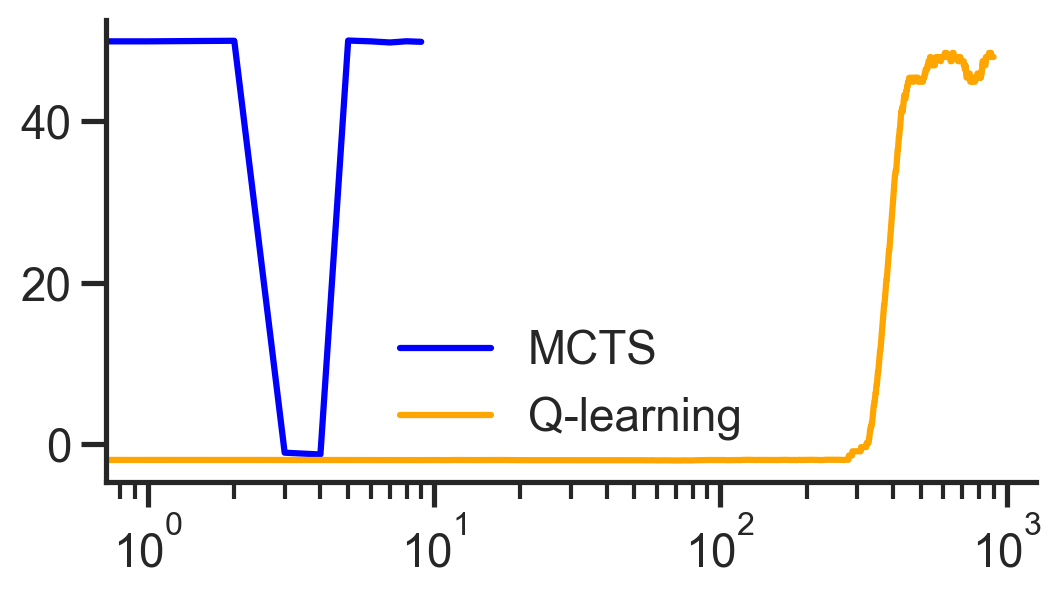

In [56]:
fig, ax = plt.subplots(1, 1, figsize=(6, 3))
smoothed_mp = np.convolve(mp_q2, np.ones(100)/100, mode='valid')
plt.plot(range(len(mp_mcts2)), mp_mcts2, label='MCTS', color='blue')
plt.plot(range(len(smoothed_mp)), smoothed_mp, label='Q-learning', color='orange')
plt.legend()
plt.xscale('log')